# Inverse distance weighting - Meuse Dataset

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


In [4]:
meuse_df = pd.read_csv("Data/meuse_processed.csv")

In [5]:
display(meuse_df)

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m,cluster_num
0,181072,333611,2.459589,4.442651,5.700444,6.929517,7.909,0.001358,13.6,1,1,1,Ah,50,0
1,181025,333558,2.151762,4.394449,5.624018,7.039660,6.983,0.012224,14.0,1,1,1,Ah,30,0
2,181165,333537,1.871802,4.219508,5.293305,6.461468,7.800,0.103029,13.0,1,1,1,Ah,150,0
3,181298,333484,0.955511,4.394449,4.753590,5.549076,7.655,0.190094,8.0,1,2,0,Ga,270,0
4,181307,333330,1.029619,3.871201,4.762174,5.594711,7.480,0.277090,8.7,1,2,0,Ah,380,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,179184,330182,-0.223144,2.995732,3.891820,5.111988,8.128,0.423837,4.7,3,1,0,Am,540,7
151,179085,330292,1.131402,3.663562,5.153292,6.206576,8.577,0.423837,9.1,3,1,0,Ah,520,7
152,178875,330311,0.741937,3.433987,4.779123,5.834811,8.429,0.277090,6.5,3,1,0,Ah,350,1
153,179466,330381,-0.223144,3.044522,3.931826,5.087596,9.406,0.358606,5.7,3,1,0,W,460,7


## Splitting Data

In [8]:
# Convert columns to numpy arrays
observed_location_columns_meuse = ['x', 'y','cluster_num']
observed_values_column_meuse = 'zinc'
observed_locations_meuse = meuse_df[observed_location_columns_meuse].values
observed_values_meuse = meuse_df[observed_values_column_meuse].values

In [9]:
X_train_meuse, X_test_meuse, y_train_meuse, y_test_meuse = train_test_split(observed_locations_meuse,
                                                                            observed_values_meuse, test_size=0.2, random_state=0)
print(f"X_train_meuse.shape: {X_train_meuse.shape}")
print(f"X_test_meuse.shape:  {X_test_meuse.shape}")
print(f"y_train_meuse.shape: {y_train_meuse.shape}")
print(f"y_test_meuse.shape:  {y_test_meuse.shape}")

X_train_meuse.shape: (124, 3)
X_test_meuse.shape:  (31, 3)
y_train_meuse.shape: (124,)
y_test_meuse.shape:  (31,)


## Understanding distribution of clusters in train and test sets

In [10]:
x_values = [element[0] for element in X_train_meuse]
y_values = [element[1] for element in X_train_meuse]
cluster_values = [element[2] for element in X_train_meuse]

data = {
    'x': x_values,
    'y': y_values,
    'cluster_num': cluster_values
}

train_df = pd.DataFrame(data)
train_df['cluster_num'] = train_df['cluster_num'].astype('category')

x_values_test = [element[0] for element in X_test_meuse]
y_values_test = [element[1] for element in X_test_meuse]
cluster_values_test = [element[2] for element in X_test_meuse]

data_test  = {
    'x': x_values_test,
    'y': y_values_test,
    'cluster_num': cluster_values_test
}

test_df = pd.DataFrame(data_test)
test_df['cluster_num'] = test_df['cluster_num'].astype('category')

In [11]:
train_df.describe(include='all')

,x,y,cluster_num
count,124.000000,124.000000,124.0
unique,NaN,NaN,8.0
top,NaN,NaN,0.0
freq,NaN,NaN,19.0
mean,180033.290323,331681.548387,NaN
std,744.898103,1048.719020,NaN
min,178605.000000,329714.000000,NaN
25%,179437.250000,330792.500000,NaN
50%,180083.500000,331697.000000,NaN
75%,180655.000000,332509.250000,NaN


<Axes: >

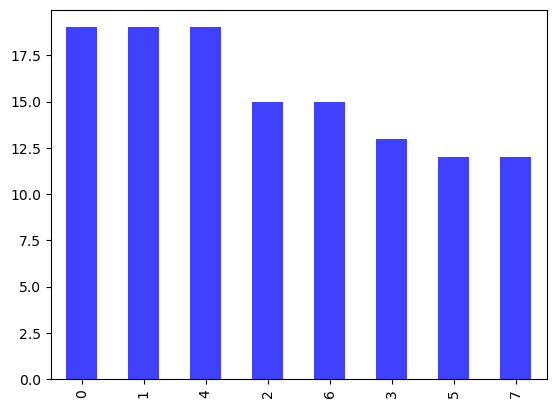

In [12]:
# Count the occurrences of each category
category_counts = train_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue')

In [13]:
test_df.describe(include='all')

,x,y,cluster_num
count,31.000000,31.000000,31.0
unique,NaN,NaN,8.0
top,NaN,NaN,1.0
freq,NaN,NaN,9.0
mean,179889.838710,331448.483871,NaN
std,751.728191,1039.762148,NaN
min,178803.000000,329733.000000,NaN
25%,179150.000000,330572.500000,NaN
50%,179792.000000,331150.000000,NaN
75%,180486.000000,332314.500000,NaN


<Axes: >

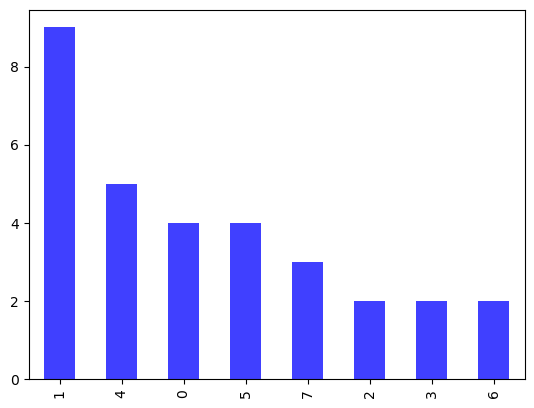

In [14]:
# Count the occurrences of each category
category_counts = test_df['cluster_num'].value_counts()

# Plotting
category_counts.plot(kind='bar', alpha=0.75, color='blue')

## Spatial K-Fold Cross Validation

In [15]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_meuse]
y_data_train = [inner_list[1] for inner_list in X_train_meuse]
cluster_num_data_train = [inner_list[2] for inner_list in X_train_meuse]

In [27]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'cluster_num':cluster_num_data_train, 
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}
powers_list = [1,2,3,4,5,6,7,8]

start_time = time.time()
#For each possible hyperparameter, conduct K-Fold CV
for power in powers_list:
    
    
    # Define K-Fold cross-validation
    group_kfold = GroupKFold(n_splits = 8)
    #kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []

    # Perform K-Fold cross-validation
    for train_index, test_index in group_kfold.split(cv_data['X'],cv_data['Y'],cv_data['cluster_num']):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = power)
        
        # Calculate Metrics and append the validation score for each split into cv_scores_metric
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
        
    # Calulcate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)
    
    
    # Store the mean CV score for each metric for this iteration of theoratical model chosen
    cv_score_list[power] = {
        "Mean CV Score MAE" : mean_validation_score_mae,
        "Mean CV Score RMSE" : mean_validation_score_rmse,
        "Mean CV Score MAPE" : mean_validation_score_mape,
        "Mean CV Score R Squared" : mean_validation_score_r2
        
    }

end_time = time.time()
# Now there is a dictionary of mean CV scores for 3 different metrics for each possible model 
display(pd.DataFrame(cv_score_list))

smallest_scores = {
    "Mean CV Score MAE": {"value": float('inf'), "model": None},
    "Mean CV Score RMSE": {"value": float('inf'), "model": None},
    "Mean CV Score MAPE": {"value": float('inf'), "model": None},
    "Mean CV Score R Squared": {"value": float('-inf'), "model": None} # Changed to '-inf' for maximization
}

# Iterate through each model's scores in the dictionary
for model, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "Mean CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "Mean CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")
        
print(f"Training Computation Time: {end_time - start_time:.2f} seconds")

,1,2,3,4,5,6,7,8
Mean CV Score MAE,0.529570,0.495527,0.464351,0.440559,0.426887,0.421499,0.421959,0.424648
Mean CV Score RMSE,0.632787,0.601008,0.576264,0.560910,0.553921,0.553352,0.557055,0.563104
Mean CV Score MAPE,0.087348,0.081305,0.075767,0.071541,0.069054,0.068022,0.068047,0.068477
Mean CV Score R Squared,-0.019404,0.094913,0.180359,0.231925,0.256112,0.260815,0.253050,0.238335


The smallest Mean CV Score MAE is 0.4214985480882859, found in power 6.
The smallest Mean CV Score RMSE is 0.5533522026493014, found in power 6.
The smallest Mean CV Score MAPE is 0.06802194554561734, found in power 6.
The largest Mean CV Score R Squared is 0.2608154813160891, found in power 6.
Training Computation Time: 0.13 seconds


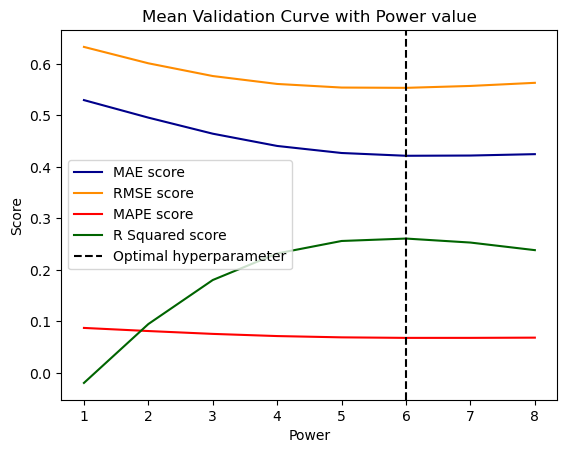

In [28]:
power = 6
df = pd.DataFrame(cv_score_list).T
plt.plot(powers_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
plt.plot(powers_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(powers_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
plt.plot(powers_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(power, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('Power')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.title("Mean Validation Curve with Power value")
plt.show()

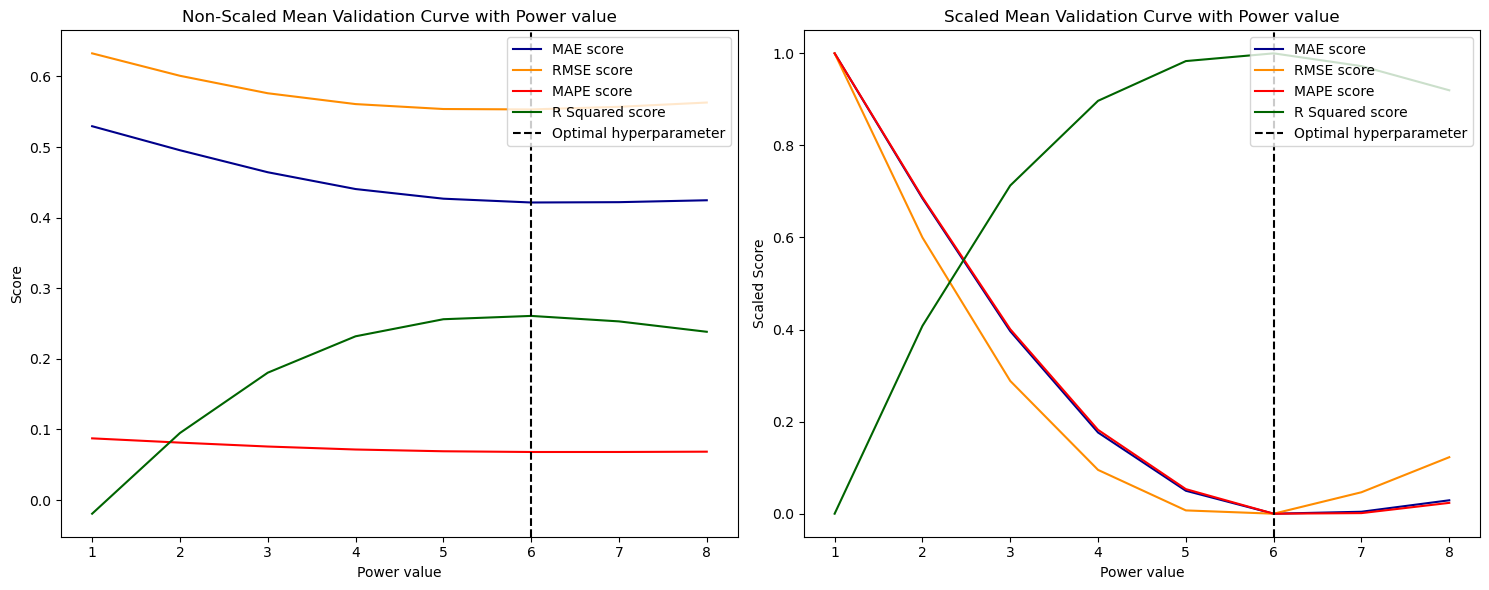

In [29]:
df = pd.DataFrame(cv_score_list).T
power = 6
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Mean Validation Curve with Power value")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Mean CV Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Mean CV Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Mean Validation Curve with Power value")

plt.tight_layout()
plt.show()

### n_neighbors

In [36]:
cv_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'cluster_num':cluster_num_data_train, 
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}

# For each possible number of neighbors, conduct K-Fold CV
n_neighbors_list = [2, 4, 6, 8, 10, 12,14,16,18,20]

start_time = time.time()

for n_neighbors in n_neighbors_list:
    
    # Define K-Fold cross-validation
    group_kfold = GroupKFold(n_splits = 8)
    #kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []
    cv_scores_r2 = []


    # Perform K-Fold cross-validation
    for train_index, test_index in group_kfold.split(cv_data['X'],cv_data['Y'],cv_data['cluster_num']):
        train_data = cv_data.iloc[train_index]
        test_data = cv_data.iloc[test_index]
        
        combined_array_train = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])
        idw_model = ShepardIDWInterpolator(combined_array_train, train_data['Z'])
        
        # Predict at test locations
        combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
        z_pred_train = idw_model.__call__(combined_array_test, power = 6, n_neighbors = n_neighbors)
        
        # Calculate Metrics
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_train))
        mae = mean_absolute_error(test_data['Z'], z_pred_train)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred_train)
        r2 = r2_score(test_data['Z'], z_pred_train)
        
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        cv_scores_r2.append(r2)
    
        
    # Calculate mean CV score for all splits for each metric    
    mean_validation_score_mae = np.mean(cv_scores_mae)
    mean_validation_score_rmse = np.mean(cv_scores_rmse)
    mean_validation_score_mape = np.mean(cv_scores_mape)
    mean_validation_score_r2 = np.mean(cv_scores_r2)

    
    # Store the mean CV score for each metric for this iteration of n_neighbors chosen
    cv_score_list[n_neighbors] = {
        "Mean CV Score MAE": mean_validation_score_mae,
        "Mean CV Score RMSE": mean_validation_score_rmse,
        "Mean CV Score MAPE": mean_validation_score_mape,
        "Mean CV Score R Squared": mean_validation_score_r2
    }
end_time = time.time()

# Display the results
display(pd.DataFrame(cv_score_list))  # Transposed for better readability

smallest_scores = {
    "Mean CV Score MAE": {"value": float('inf'), "model": None},
    "Mean CV Score RMSE": {"value": float('inf'), "model": None},
    "Mean CV Score MAPE": {"value": float('inf'), "model": None},
    "Mean CV Score R Squared": {"value": float('-inf'), "model": None} # Changed to '-inf' for maximization
}

# Iterate through each model's scores in the dictionary
for model, scores in cv_score_list.items():
    for score_type, score_value in scores.items():
        # Special handling for R Squared to find the maximum
        if score_type == "Mean CV Score R Squared":
            if score_value > smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model
        # For all other metrics, we find the minimum
        else:
            if score_value < smallest_scores[score_type]["value"]:
                smallest_scores[score_type]["value"] = score_value
                smallest_scores[score_type]["model"] = model

# Display the results
for score_type, info in smallest_scores.items():
    if score_type == "Mean CV Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
        
print(f"Training Computation Time: {end_time - start_time:.2f} seconds")

,2,4,6,8,10,12,14,16,18,20
Mean CV Score MAE,0.442738,0.433139,0.420340,0.421499,0.424301,0.425454,0.427415,0.426765,0.426012,0.424705
Mean CV Score RMSE,0.598314,0.574019,0.556379,0.553352,0.556071,0.555690,0.555696,0.553524,0.551164,0.549358
Mean CV Score MAPE,0.071719,0.069911,0.067766,0.068022,0.068568,0.068801,0.069191,0.069115,0.069025,0.068814
Mean CV Score R Squared,0.139972,0.211513,0.255419,0.260815,0.252289,0.252658,0.251497,0.257919,0.264336,0.269496


The smallest Mean CV Score MAE is 0.4203400889459196, found in n_neighbors 6.
The smallest Mean CV Score RMSE is 0.5493578359128849, found in n_neighbors 20.
The smallest Mean CV Score MAPE is 0.06776624739355458, found in n_neighbors 6.
The largest Mean CV Score R Squared is 0.26949612892374686, found in n_neighbors 20.
Training Computation Time: 0.16 seconds


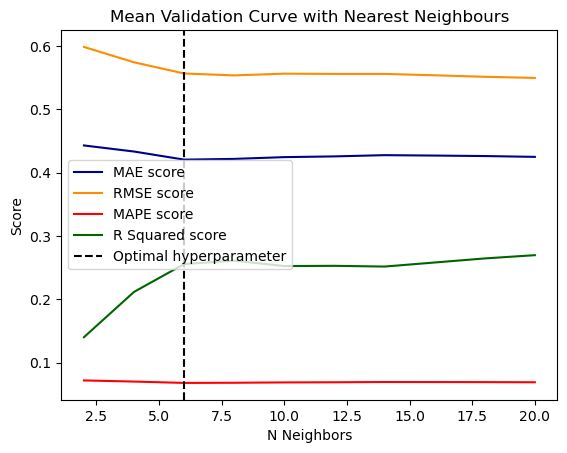

In [37]:
n_neighbors = 6
df = pd.DataFrame(cv_score_list).T
plt.plot(n_neighbors_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
plt.plot(n_neighbors_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
plt.plot(n_neighbors_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
plt.plot(n_neighbors_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
plt.axvline(n_neighbors, c='k', ls='--', label = "Optimal hyperparameter")

plt.xlabel('N Neighbors')
plt.ylabel('Score')
#plt.yscale('log')
plt.legend()
plt.title("Mean Validation Curve with Nearest Neighbours")
plt.show()

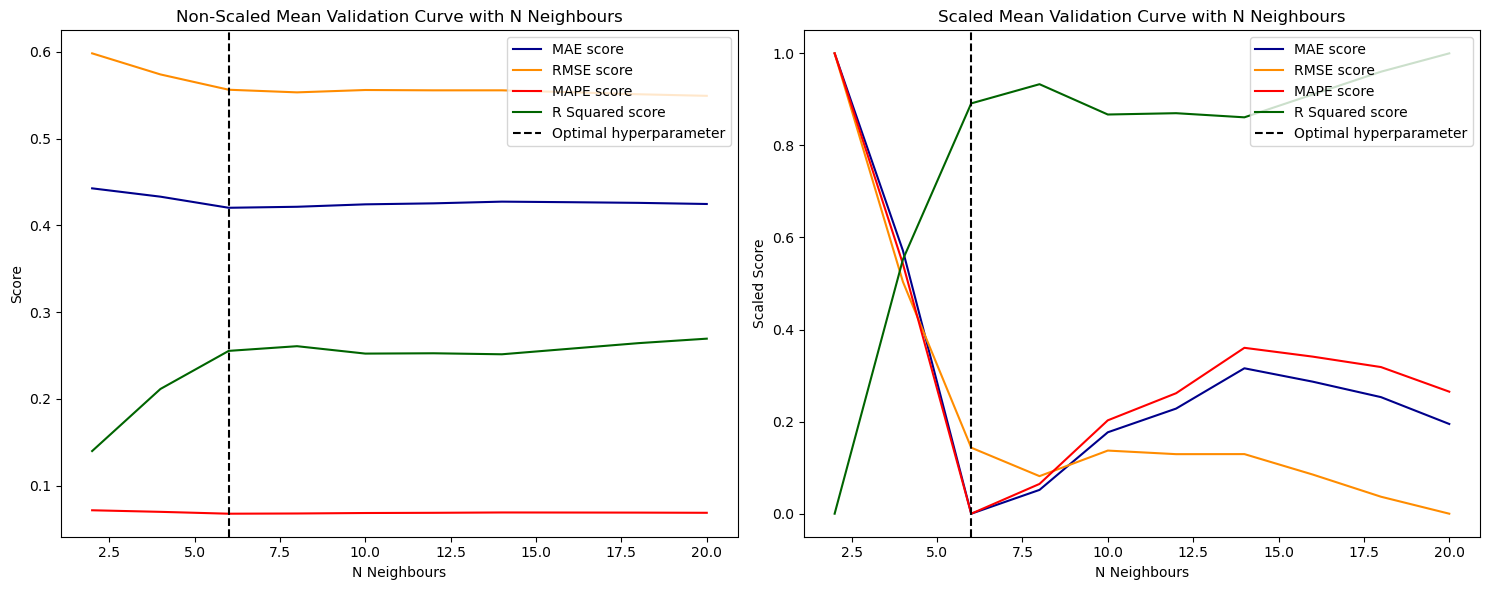

In [38]:
df = pd.DataFrame(cv_score_list).T
n_neighbors = 6
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Mean CV Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Mean CV Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbours')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Mean Validation Curve with N Neighbours")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Mean CV Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Mean CV Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Mean CV Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Mean CV Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbours')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Mean Validation Curve with N Neighbours")

plt.tight_layout()
plt.show()

## Hyperparameter selection

As we can see, power = 6 and n_neighbors = 6 would be the most optimal option.

## Evaluation of Model (Testing Chosen model)

### Performance Metrics of Model

In [39]:
# Using list comprehension
x_data_train = [inner_list[0] for inner_list in X_train_meuse]
y_data_train = [inner_list[1] for inner_list in X_train_meuse]

train_data = pd.DataFrame({
    'X': x_data_train,
    'Y': y_data_train,
    'Z': y_train_meuse
})

x_data_test = [inner_list[0] for inner_list in X_test_meuse]
y_data_test = [inner_list[1] for inner_list in X_test_meuse]

test_data = pd.DataFrame({
    'X': x_data_test,
    'Y': y_data_test,
    'Z': y_test_meuse
})

eval_combined_array_coordinates = np.array([list(pair) for pair in zip(train_data['X'], train_data['Y'])])

start_time = time.time()

idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, train_data['Z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_data['X'], test_data['Y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 6, n_neighbors = 6)

rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred_test))
mae = mean_absolute_error(test_data['Z'], z_pred_test)
mape = mean_absolute_percentage_error(test_data['Z'], z_pred_test)
r2 = r2_score(test_data['Z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.30091664660944256
RMSE: 0.42722338438899127
MAPE: 0.052187784751690634
R Squared: 0.5818051092306955
Testing Computation Time: 0.01 seconds


### Plotting Spatial Interpolation of entire area with Model

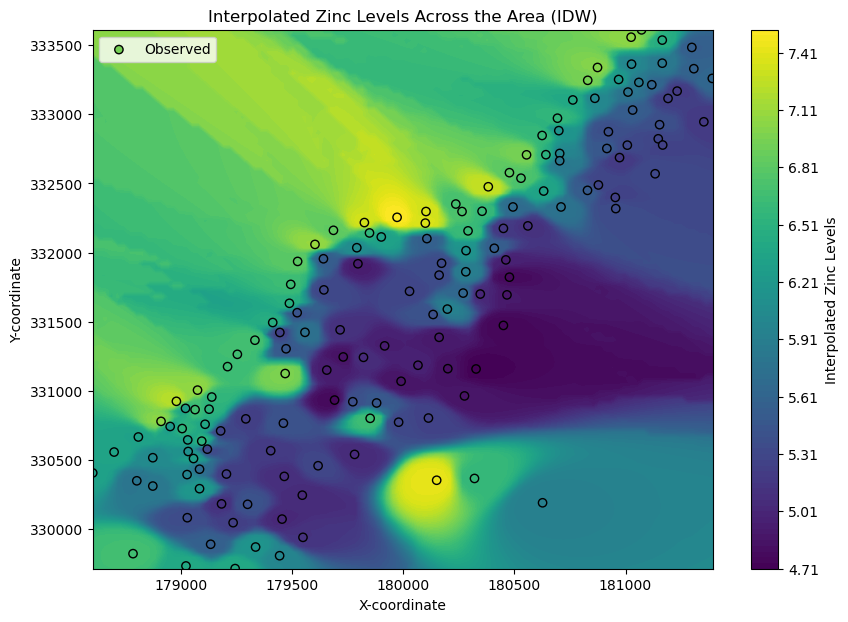

Spatial Interpolation Computation Time: 0.23 seconds


In [40]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations, observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 6, n_neighbors = 6)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Zinc Levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

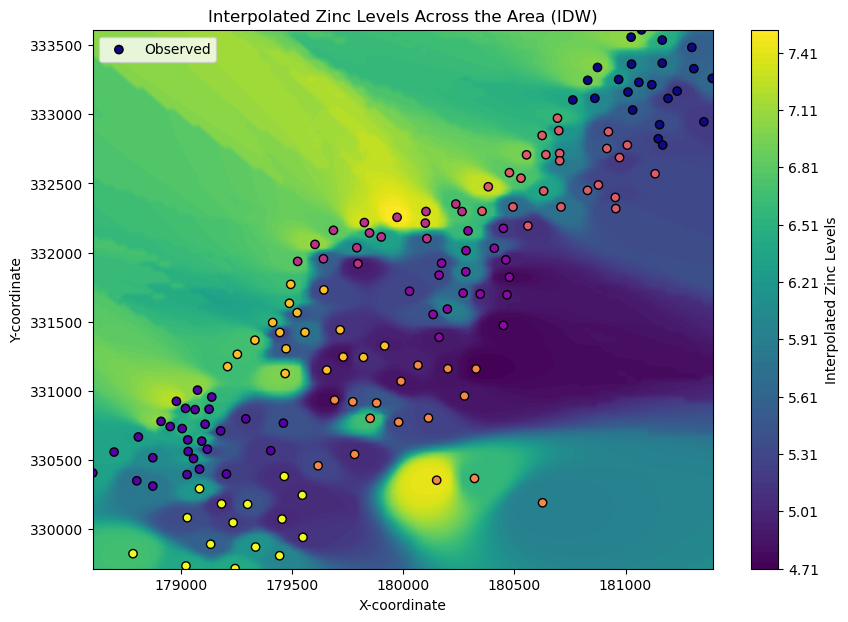

Spatial Interpolation Computation Time: 0.46 seconds


In [6]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'zinc'
observed_locations = meuse_df[observed_location_columns].values
observed_values = meuse_df[observed_values_column].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations, observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 6, n_neighbors = 6)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Zinc Levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['cluster_num'], cmap='plasma', edgecolor='k', label='Observed')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")

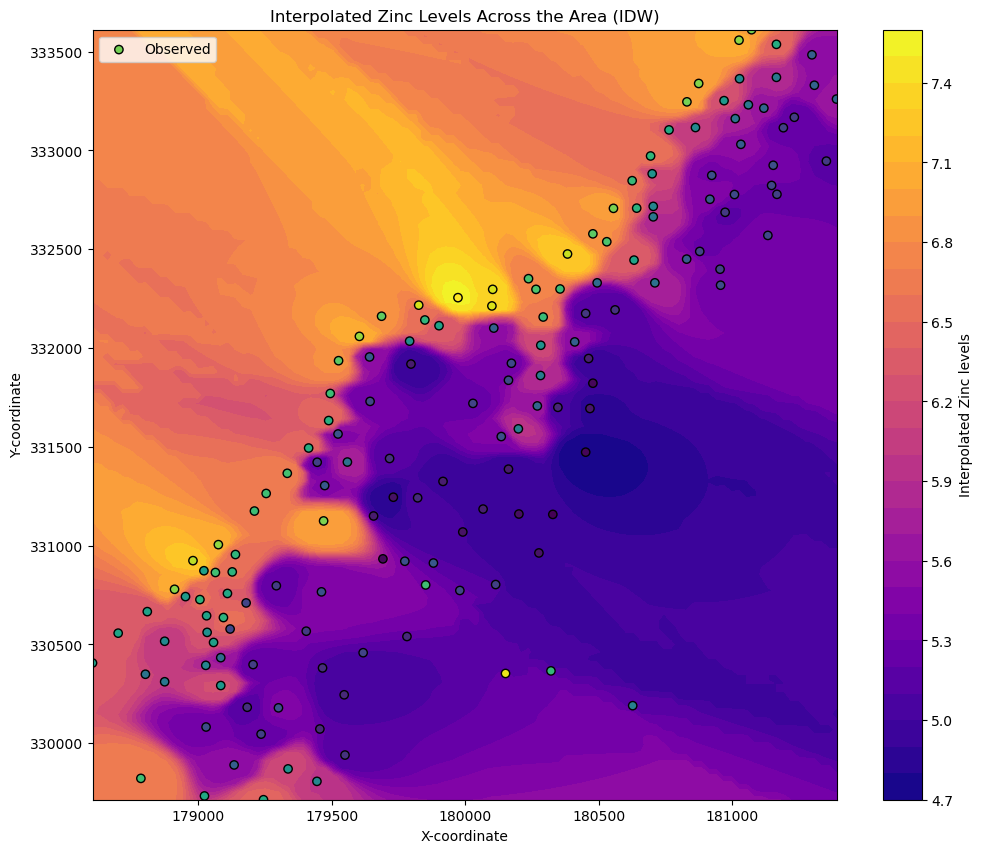

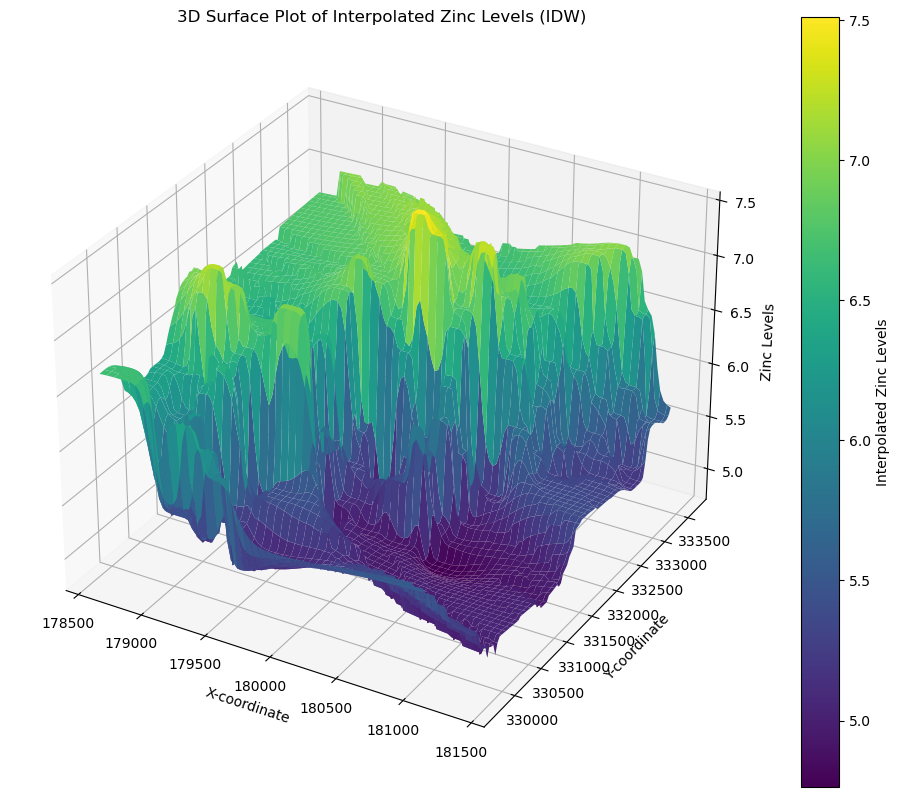

In [44]:
# Adjust the zoom by reducing the buffer around the min and max values
buffer = 0.01  # Smaller buffer to zoom in closer
x_min, x_max = observed_locations[:, 0].min() - buffer, observed_locations[:, 0].max() + buffer
y_min, y_max = observed_locations[:, 1].min() - buffer, observed_locations[:, 1].max() + buffer

x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 6, n_neighbors = 6)
z_grid = interpolated_values.reshape(x_grid.shape)


fig = plt.figure(figsize=(12, 10))

from mpl_toolkits.mplot3d import Axes3D

plt.contourf(x_grid, y_grid, z_grid, cmap='plasma', levels=30)
plt.colorbar(label='Interpolated Zinc levels')
plt.scatter(meuse_df['x'], meuse_df['y'], c=meuse_df['zinc'], cmap='viridis', edgecolor='k', label='Observed')

plt.xlim(x_min, x_max)  # Set x-axis limits
plt.ylim(y_min, y_max)  # Set y-axis limits

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.title('Interpolated Zinc Levels Across the Area (IDW)')
plt.show()

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, label='Interpolated Zinc Levels')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
ax.set_zlabel('Zinc Levels')
ax.set_title('3D Surface Plot of Interpolated Zinc Levels (IDW)')
plt.show()


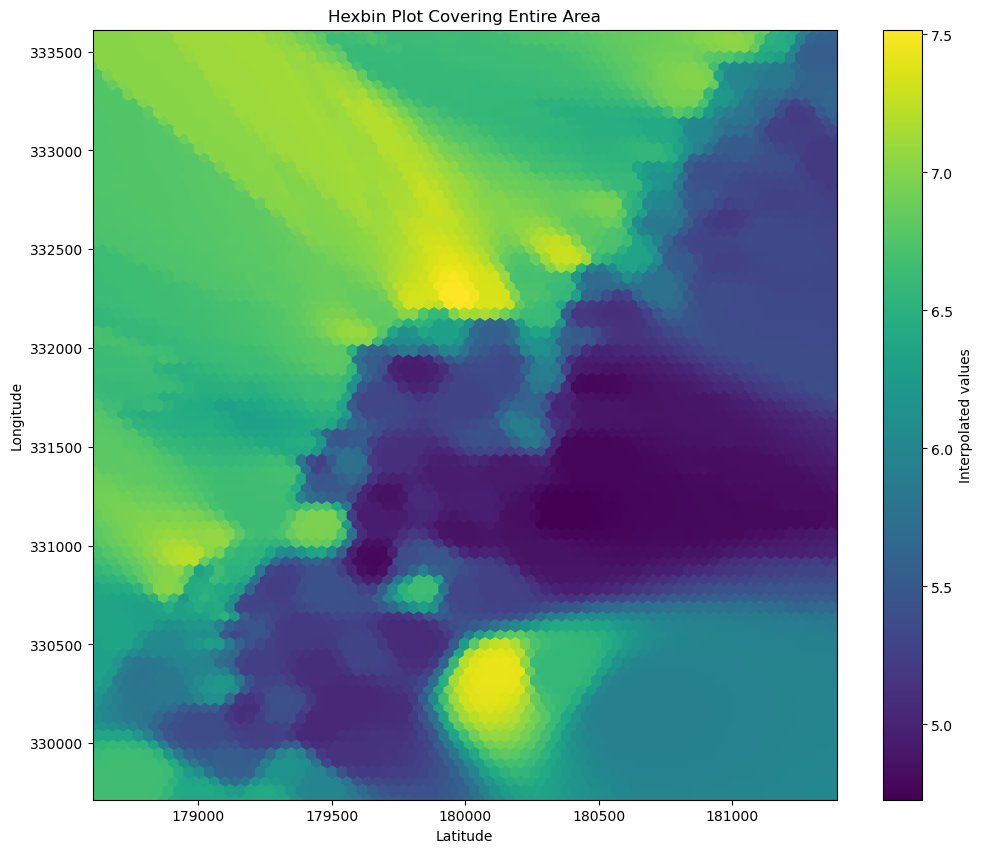

In [42]:
# Determine the minimum and maximum values for Latitude and Longitude
buffer = 0.01
lat_min, lat_max = observed_locations[:, 0].min() - buffer, observed_locations[:, 0].max() + buffer
lon_min, lon_max = observed_locations[:, 1].min() - buffer, observed_locations[:, 1].max() + buffer

# Generate a mesh grid of latitude and longitude values
grid_size = 200  # Square root of num_points, adjust as needed for resolution
latitude_range = np.linspace(lat_min, lat_max, grid_size)
longitude_range = np.linspace(lon_min, lon_max, grid_size)
lat_grid, lon_grid = np.meshgrid(latitude_range, longitude_range)

# Flatten the grid to create combined array of [latitude, longitude] pairs
combined_array = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

# Simulate interpolated_values from your IDW model or similar
interpolated_values = idw_model(combined_array, power=6, n_neighbors=6)

# Plot using hexbin
plt.figure(figsize=(12, 10))
hb = plt.hexbin(combined_array[:, 0], combined_array[:, 1], C=interpolated_values, gridsize=73, cmap='viridis', extent=(lat_min, lat_max, lon_min, lon_max))
plt.colorbar(hb, label='Interpolated values')

plt.xlim(lat_min, lat_max)
plt.ylim(lon_min, lon_max)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Hexbin Plot Covering Entire Area')
plt.show()